In [146]:
import numpy as np
from scipy.integrate import solve_ivp
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are

In [147]:
# Define integral of function f with trapezoidal rule
def integrate(h, n_modes, f):
    cum_sum = 0
    for k in range(n_modes - 1):
        cum_sum += f[k + 1] + f[k]
    return (h / 2) * cum_sum

# Define boundary conditions
def ROM_left_boundary(t):
    return np.sin(np.pi * t)

def ROM_right_boundary(t):
    return np.sin(np.pi * t)

# Define the RHS of the reduced-order model (open-loop)
def ROM_rhs_open(t, alpha):
    global A_ROM, B_ROM
    return A_ROM @ alpha + B_ROM[:,1] * ROM_right_boundary(t) + B_ROM[:,0] * ROM_left_boundary(t)

# Define the RHS of reduced-order model (closed-loop)
# def ROM_rhs_closed(t, alpha):
#     global K_ref, A_ref, B_ref, B_ROM
#     return (A_ref - B_ref * K_ref) * alpha

In [148]:
'''
Diffusion eqn: w_t = D * w_xx
Solution: w = sum(alpha(t) * PHI(x))

Weak form ODE: w_t = Aw + Bu
State-space form: (alpha_t)_j = A_ji * alpha_i + B
'''
# Parameters
dt = 2e-05
T = 1
nu = 1000
D = 0.01 # Diffusivity
h = 0.01 #(dx)
a = 0
b = 1

# Load POD data (POD modes and spatial derivatives)
PHI = np.load('POD_data_ROM.npz')['PHI']
dPHI_dx = np.load('POD_data_ROM.npz')['dPHI_dx']
nx, n_modes = PHI.shape

# snapshots = np.load('snapshots.npy') # Load snapshots data

B_ROM = np.zeros((n_modes, 2))
B_ROM[:,0] = (D / h) * PHI[0, :] # left boundary in 1st column
B_ROM[:,1] = (D / h) * PHI[-1, :] # right boundary in 2nd column

A_ROM = np.zeros((n_modes, n_modes))
# Construct A_ROM matrix
for j in range(n_modes):
    jj = PHI[:, j]
    for i in range(n_modes):
        ii = PHI[:, i]
        integrand = dPHI_dx[:,i] * dPHI_dx[:,j] 
        A_ROM[j,i] = -D * (jj[-1] * ii[nx-2] / h + jj[0] * ii[1] / h + integrate(h, nx, integrand))

# Initial conditions and time span
alpha0 = np.zeros(n_modes)
t_span = [0, 1]

# Solve the ODE
solution = solve_ivp(ROM_rhs_open, t_span, alpha0, method='RK45', dense_output=True)

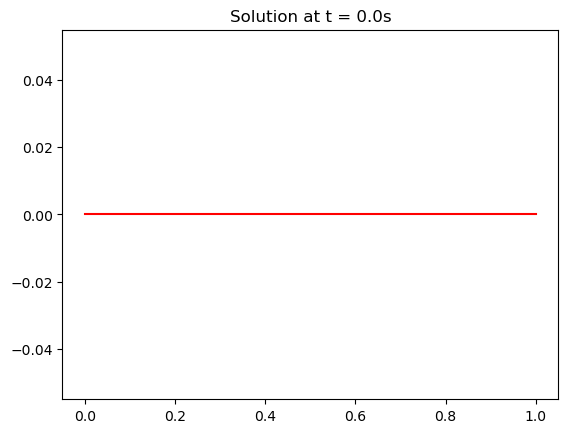

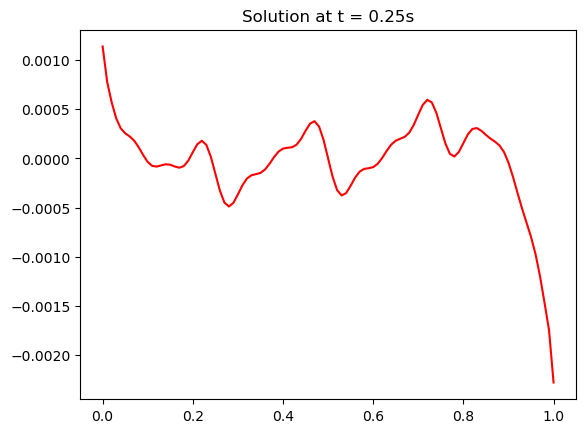

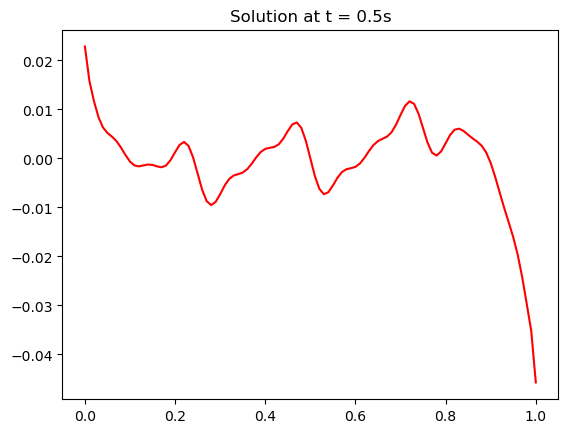

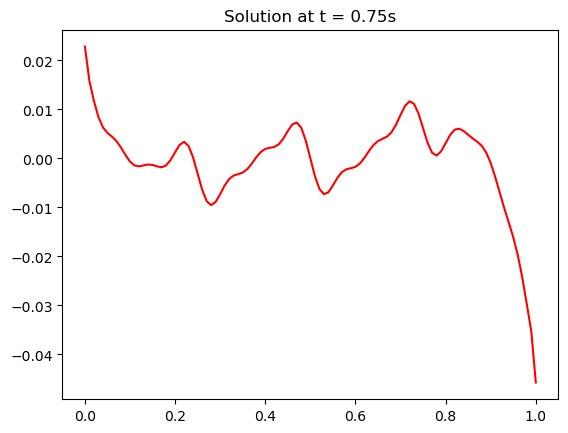

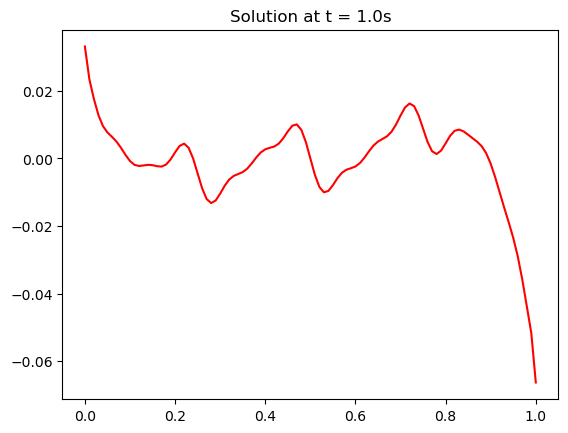

In [149]:
# Reconstruct the solution
t = solution.t
alpha = solution.y
W_reconstruction = - PHI @ alpha

# Plot results
plot_times = [0, 1, 2, 3, 4]
for plot_time in plot_times:
    idx = (np.abs(t - plot_time/4)).argmin()
    plt.figure()
    plt.plot(np.linspace(0, 1, len(PHI)), W_reconstruction[:, idx], 'r')
    plt.title(f"Solution at t = {plot_time/4}s")
    # plt.legend()
    plt.show()

# Additional processing (snapshots, steady-state checks) can be added here


In [150]:
def compute_alpha_ref(w, PHI, dx):
    """
    Compute the reference POD coefficients.
    
    Parameters:
    - w_ref: Reference state (array of size nx)
    - PHI: POD modes (array of size nx x num_modes)
    - dx: Spatial step size
    
    Returns:
    - alpha_ref: Reference POD coefficients (array of size num_modes)
    """
    return PHI.T @ (w * dx)

# Example: Define reference state
nx = 101  # Number of spatial points
L = 1.0   # Length of the domain
dx = L / (nx - 1)
x = np.linspace(0, L, nx)

# Initial state: Multi-Modal sinusoidal
A1, A2, A3 = 1.0, 0.5, 0.3	# Component amplitudes
L1, L2, L3 = L/4, L/8, L/12 # Component wavelengths
w_0 = (A1 * np.sin(2 * np.pi * x / L1) +
        A2 * np.sin(2 * np.pi * x / L2) +
        A3 * np.sin(2 * np.pi * x / L3))

# Define reference state: Simplified sinusoidal target profile
w_ref = A1 * np.sin(2 * np.pi * x / L1)


In [151]:
# Define the LQR Feedback Control
def lqr(A, B, Q, R):
    """
    Solve the continuous-time Algebraic Riccati Equation (ARE) for LQR.
    
    Parameters:
    - A: System dynamics matrix
    - B: Control influence matrix
    - Q: State weight matrix
    - R: Control weight matrix
    
    Returns:
    - K: Optimal feedback gain matrix
    """
    P = solve_continuous_are(A, B, Q, R)
    K = np.linalg.inv(R) @ B.T @ P
    return K

# Define ROM dynamics with feedback control
def rom_dynamics(t, alpha, A, B, K, alpha_ref):
    """
    Reduced-order model (ROM) dynamics with feedback control.
    
    Parameters:
    - t: Time
    - alpha: Current POD coefficients
    - A: ROM dynamics matrix
    - B: Control influence matrix
    - K: Feedback gain matrix
    - alpha_ref: Reference POD coefficients
    
    Returns:
    - d_alpha/dt: Time derivative of alpha
    """
    u = -K @ (alpha - alpha_ref)  # Feedback control
    return A @ alpha + B @ u

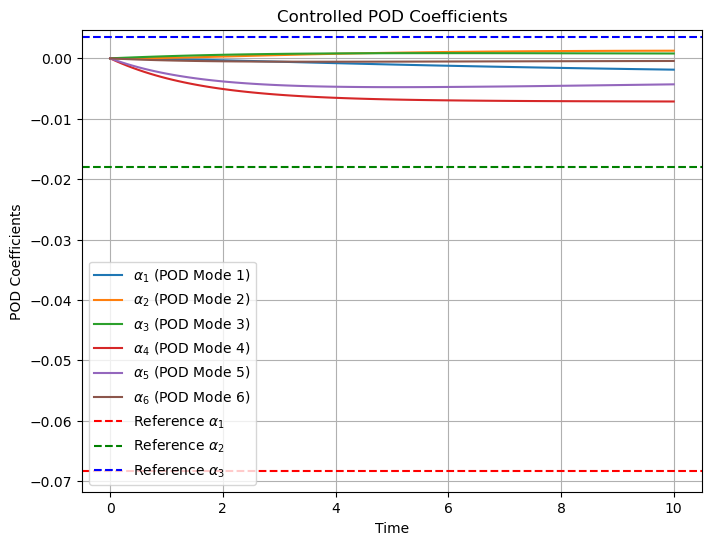

In [152]:
# Parameters for the ROM
A = A_ROM
B = B_ROM
Q = np.eye(n_modes)  # State weighting matrix
R = np.eye(B.shape[1])  # Control weighting matrix

# Compute LQR Gain
K = lqr(A, B, Q, R)

# Define reference trajectory (tracking a temperature profile)
alpha_ref = compute_alpha_ref(w_ref, PHI, dx)

# Initial conditions for the ROM
alpha_0 = compute_alpha_ref(w_0, PHI, dx)  # Initial POD coefficients
t_span = (0, 10)  # Simulation time
t_eval = np.linspace(t_span[0], t_span[1], 100)

# Solve ROM dynamics with feedback control
sol = solve_ivp(rom_dynamics, t_span, alpha0, t_eval=t_eval, args=(A, B, K, alpha_ref)
)

# Plot results
plt.figure(figsize=(8, 6))
for i in range(n_modes):
    plt.plot(sol.t, sol.y[i, :], label=rf'$\alpha_{{{i+1}}}$ (POD Mode {i+1})')
plt.axhline(alpha_ref[0], color='r', linestyle='--', label=r'Reference $\alpha_1$')
plt.axhline(alpha_ref[1], color='g', linestyle='--', label=r'Reference $\alpha_2$')
plt.axhline(alpha_ref[2], color='b', linestyle='--', label=r'Reference $\alpha_3$')

plt.title('Controlled POD Coefficients')
plt.xlabel('Time')
plt.ylabel('POD Coefficients')
plt.legend()
plt.grid(True)
plt.show()

In [153]:
def fixed_point_projection(w_full, PHI, dx, A, B, K, alpha_ref, tol=1e-6, max_iter=100):
    """
    Incorporate reduced-order control into the full-order system using fixed-point projection.
    
    Parameters:
    - w_full: Full-order solution (array of size nx)
    - PHI: POD modes (array of size nx x num_modes)
    - dx: Spatial step size
    - A, B: Reduced-order dynamics matrices
    - K: Feedback gain matrix
    - alpha_ref: Reference POD coefficients (array of size num_modes)
    - tol: Convergence tolerance for fixed-point iteration
    - max_iter: Maximum number of iterations
    
    Returns:
    - w_full: Updated full-order solution
    """
    # Project full-order state onto POD basis to initialize alpha
    alpha = PHI.T @ (w_full * dx)
    for _ in range(max_iter):
        # Compute control inputs
        u = -K @ (alpha - alpha_ref)
        
        # Update boundary conditions using control inputs
        w_full[0] = u[0]  # Control at x=0
        w_full[-1] = u[1]  # Control at x=L
        
        # Project updated full-order solution onto POD basis
        new_alpha = PHI.T @ (w_full * dx)
        
        # Check for convergence
        if np.linalg.norm(new_alpha - alpha, np.inf) < tol:
            break
        alpha = new_alpha

    return w_full

# Initialize full-order solution
w_full = np.zeros(nx)

# Apply fixed-point projection
w_full = fixed_point_projection(w_full, PHI, dx, A, B, K, alpha_ref)


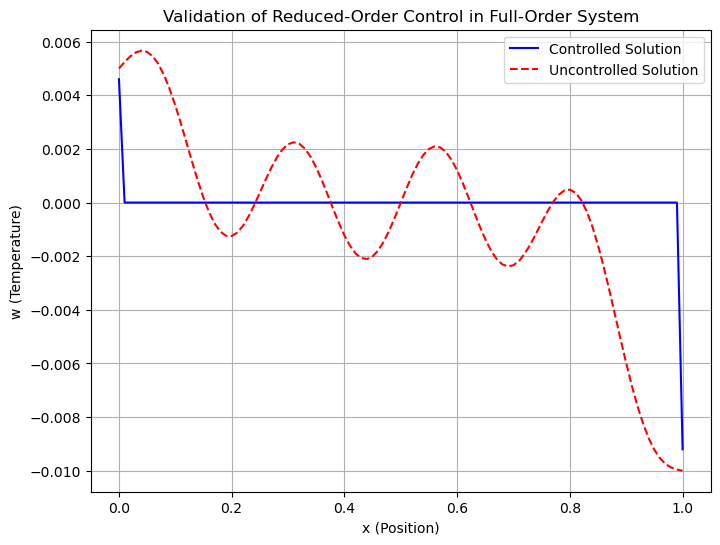

In [154]:
w = np.load('snapshots.npy')
w_uncontrolled = w[:,-1]

# Plot controlled vs uncontrolled solutions
plt.figure(figsize=(8, 6))
plt.plot(x, w_full, label='Controlled Solution', color='b')
plt.plot(x, w_uncontrolled, label='Uncontrolled Solution', color='r', linestyle='--')
plt.title('Validation of Reduced-Order Control in Full-Order System')
plt.xlabel('x (Position)')
plt.ylabel('w (Temperature)')
plt.legend()
plt.grid(True)
plt.show()